<a href="https://colab.research.google.com/github/dsevero/generative-models/blob/master/experiments/GAN/notebooks/goodfellow_2014.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

# Generative Adversarial Nets (Goodfellow 2014)


**References:**
* https://arxiv.org/pdf/1406.2661.pdf



## Autograd
(doesn't work very well :/, training time is harsh maybe using jax will suffice)

**References:** 
* https://github.com/HIPS/autograd/blob/master/examples/generative_adversarial_net.py

In [0]:
!nvcc --version

In [0]:
%matplotlib inline

In [0]:
# necessary for autograd compatibility
!pip install scipy==1.1.0 -q

# update tensorflow
!pip install tensorflow==2.0.0b1 -q

In [0]:
import autograd.numpy as np
import autograd.numpy.random as npr
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
from autograd import grad
from autograd.misc import flatten
from autograd.misc.optimizers import adam, rmsprop, sgd
from scipy.stats import norm


warnings.simplefilter(action='ignore', category=FutureWarning)

In [0]:
def show_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

### Definitions and Tests

In [0]:
def relu(x):       
    return np.maximum(0, x)

def sigmoid(x):    
    return 0.5 * (np.tanh(x) + 1.0)

def logsigmoid(x): 
    return x - np.logaddexp(0, x)

def init_random_params(scale, layer_sizes, rs=npr.RandomState(0)):
    """Build a list of (weights, biases) tuples,
       one for each layer in the net."""
    return [(scale * rs.randn(m, n),   # weight matrix
             scale * rs.randn(n))      # bias vector
            for m, n in zip(layer_sizes[:-1], layer_sizes[1:])]

def batch_normalize(activations):
    mbmean = np.mean(activations, axis=0, keepdims=True)
    return (activations - mbmean) / (np.std(activations, axis=0, keepdims=True) + 1)

def neural_net_predict(params, inputs, use_batch_norm=True):
    """Params is a list of (weights, bias) tuples.
       inputs is an (N x D) matrix."""
    inpW, inpb = params[0]
    inputs = relu(np.dot(inputs, inpW) + inpb)
    for W, b in params[1:-1]:
        outputs = np.dot(inputs, W) + b
        if use_batch_norm:
            outputs = batch_normalize(outputs)
        inputs = relu(outputs)
    outW, outb = params[-1]
    outputs = np.dot(inputs, outW) + outb
    return outputs

def generator(params, noise):
    samples = neural_net_predict(params, noise)
    return sigmoid(samples)

def discriminator(params, inputs):
    samples = neural_net_predict(params, inputs)
    return sigmoid(samples)

In [0]:
params = 5*((np.eye(3), np.zeros(3)),)
x =  npr.randn(9).reshape((3,3))
zeros = np.array([0, 0, 0])

assert (batch_normalize(zeros) == zeros).all()
assert (batch_normalize(np.array([-1, 1])) == np.array([-0.5, 0.5])).all()
assert (batch_normalize(np.array([[-1, 1], [-2, 2]])) == np.array([[1/3, -1/3], [-1/3, 1/3]])).all()

assert (neural_net_predict(params, x, False) == relu(x)).all()

### 5 Experiments (MNIST)

In [13]:
# Training parameters
param_scale = 0.001
batch_size = 1_000 # must divide 70_000.
num_epochs = 10
num_batches = int(70_000/batch_size)


# Load, concatenate and reshape the data.
# Here we don't distinguish between train and test.
# Final dimensions are (batch, image_example, image_row, image_column)
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()
images = (np.concatenate((train_images, test_images))
            .reshape((num_batches, batch_size, 28, 28))) / 255

# Model hyper-parameters
noise_dim = 100
gen_layer_sizes = [noise_dim, 50, 50, 784]
dsc_layer_sizes = [gen_layer_sizes[-1], 50, 50, 1]

# Initialize NN params. for G and D
init_gen_params = init_random_params(param_scale, gen_layer_sizes)
init_dsc_params = init_random_params(param_scale, dsc_layer_sizes)

print('images.shape:', images.shape)

images.shape: (70, 1000, 28, 28)


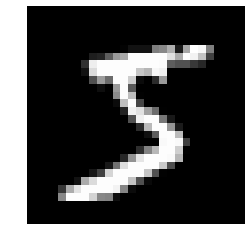

In [9]:
# Real image
show_image(images[0, 0])

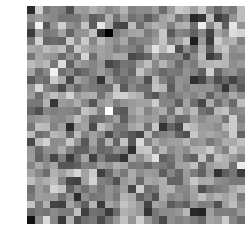

array([[0.49985975]])

In [10]:
# Initial random image from G
z = npr.rand(1, noise_dim)
fake_image = generator(init_gen_params, z)
show_image(fake_image.reshape(28, 28))

# What D knows about the random image (i.e. nothing!)
discriminator(init_dsc_params, fake_image)

In [11]:
# Even real images he has no clue on what is going on!
five_real_images = images[0, :5]
discriminator(init_dsc_params, five_real_images.reshape(5, 28*28))

array([[0.49985977],
       [0.49985974],
       [0.49985973],
       [0.49985978],
       [0.49985976]])

Iteration 0;


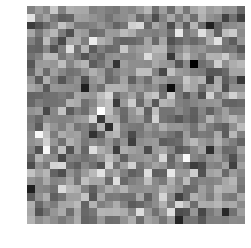

Iteration 1;


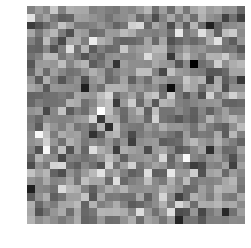

Iteration 2;


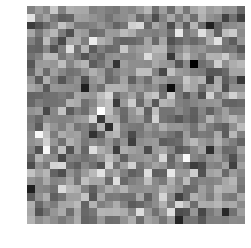

Iteration 3;


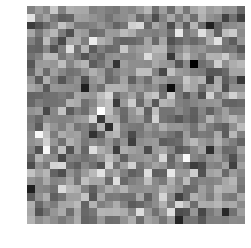

Iteration 4;


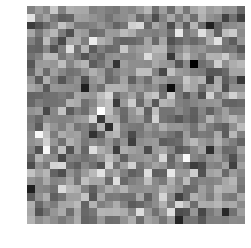

Iteration 5;


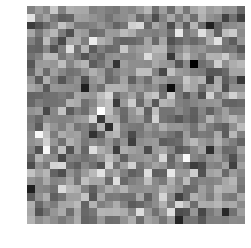

Iteration 6;


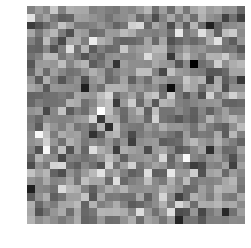

Iteration 7;


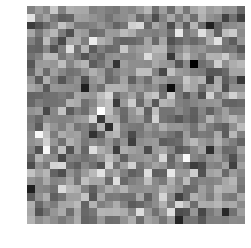

Iteration 8;


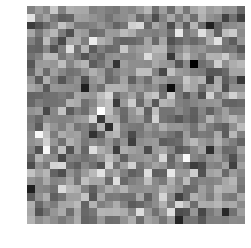

Iteration 9;


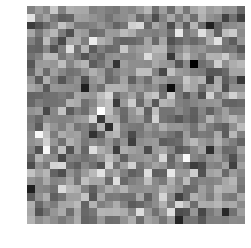

Iteration 10;


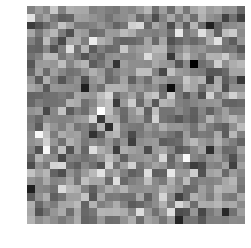

Iteration 11;


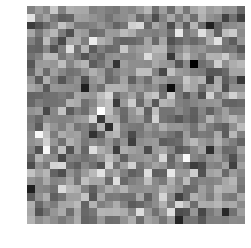

Iteration 12;


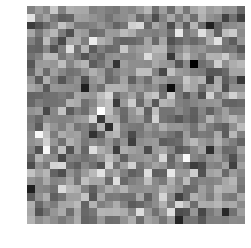

Iteration 13;


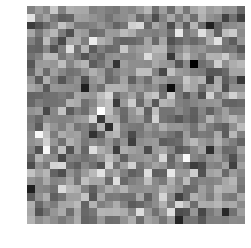

Iteration 14;


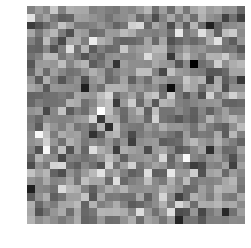

Iteration 15;


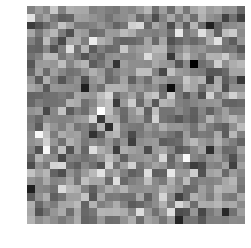

Iteration 16;


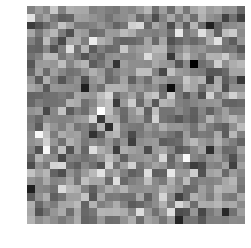

Iteration 17;


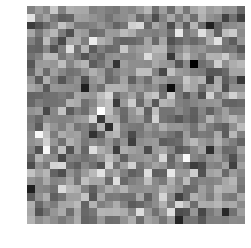

Iteration 18;


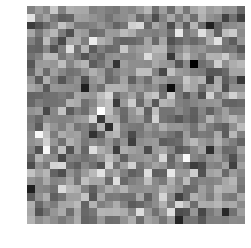

Iteration 19;


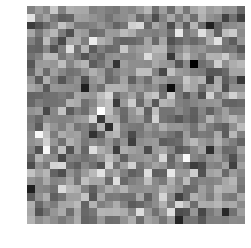

Iteration 20;


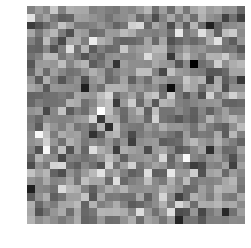

Iteration 21;


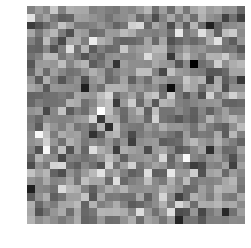

Iteration 22;


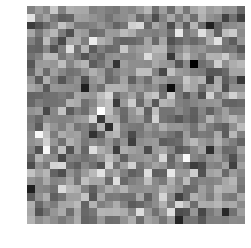

Iteration 23;


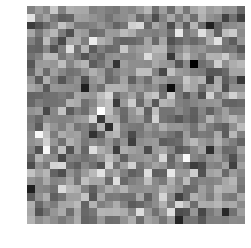

Iteration 24;


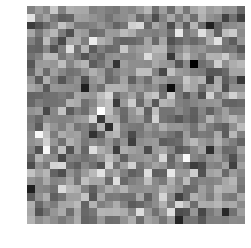

Iteration 25;


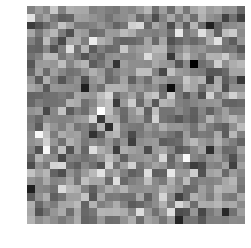

Iteration 26;


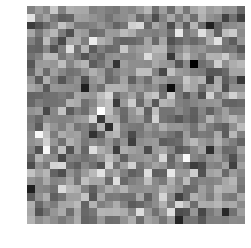

Iteration 27;


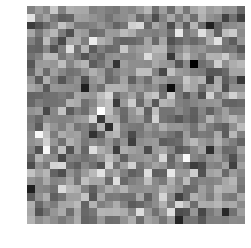

Iteration 28;


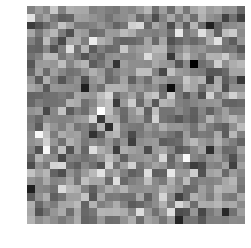

Iteration 29;


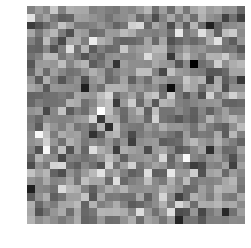

Iteration 30;


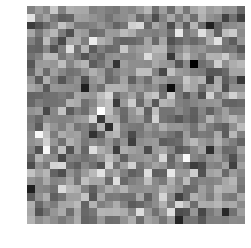

Iteration 31;


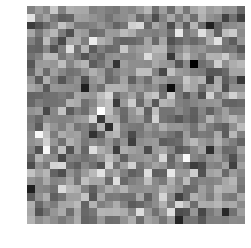

Iteration 32;


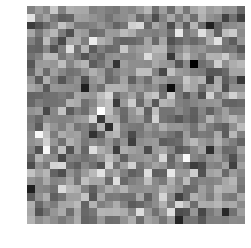

Iteration 33;


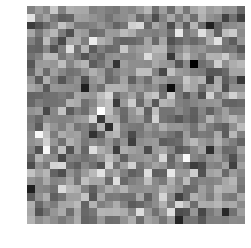

Iteration 34;


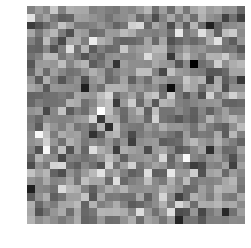

Iteration 35;


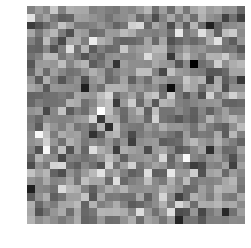

Iteration 36;


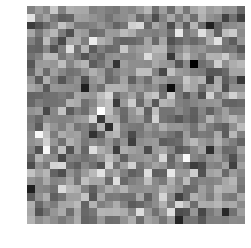

Iteration 37;


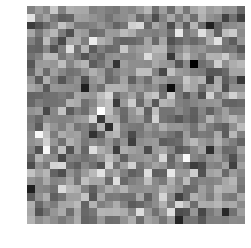

Iteration 38;


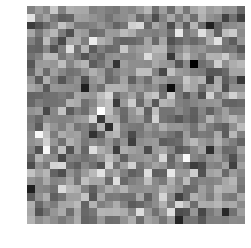

Iteration 39;


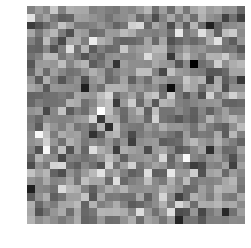

Iteration 40;


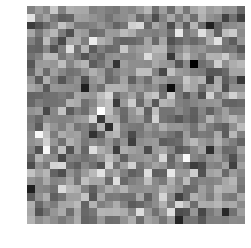

Iteration 41;


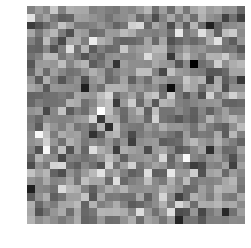

Iteration 42;


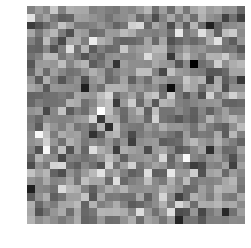

Iteration 43;


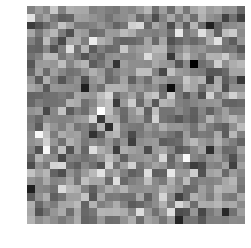

Iteration 44;


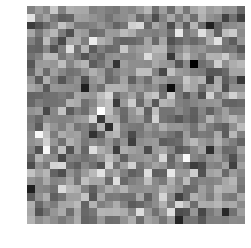

Iteration 45;


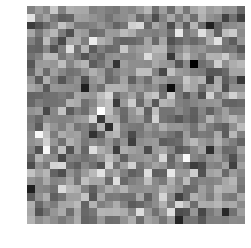

Iteration 46;


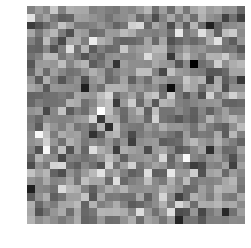

Iteration 47;


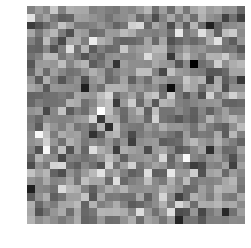

Iteration 48;


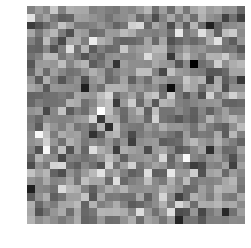

Iteration 49;


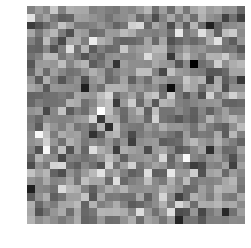

Iteration 50;


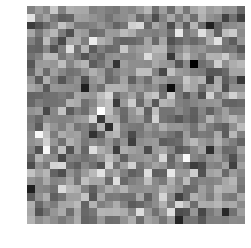

Iteration 51;


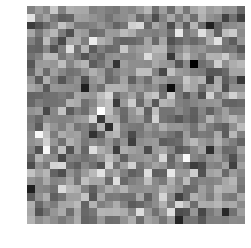

Iteration 52;


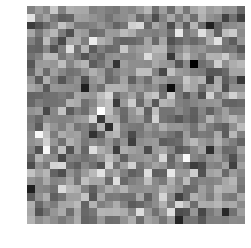

Iteration 53;


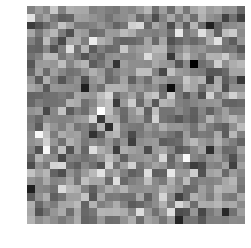

Iteration 54;


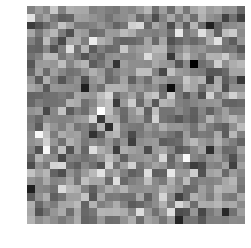

Iteration 55;


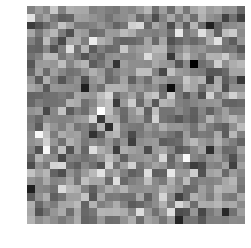

Iteration 56;


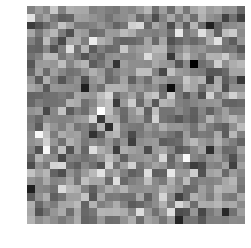

Iteration 57;


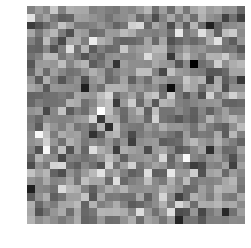

Iteration 58;


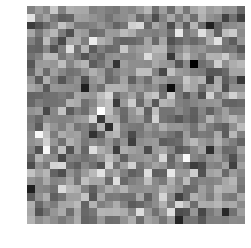

Iteration 59;


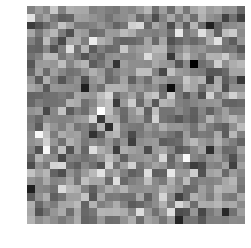

Iteration 60;


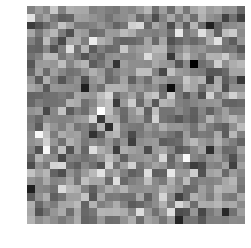

Iteration 61;


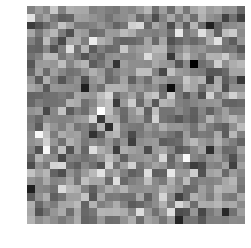

Iteration 62;


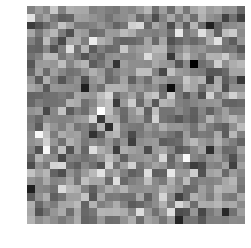

Iteration 63;


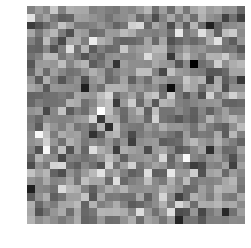

Iteration 64;


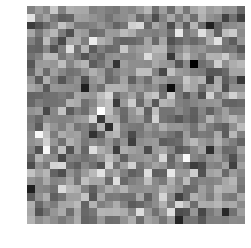

Iteration 65;


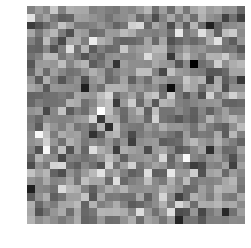

Iteration 66;


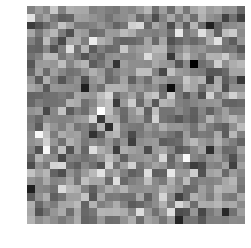

Iteration 67;


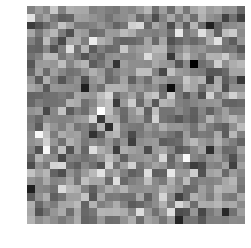

Iteration 68;


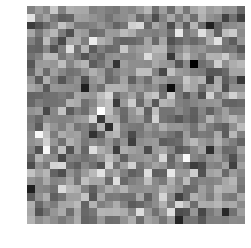

Iteration 69;


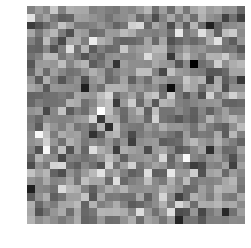

Iteration 70;


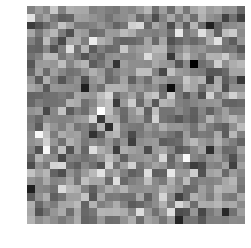

Iteration 71;


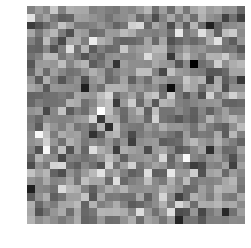

Iteration 72;


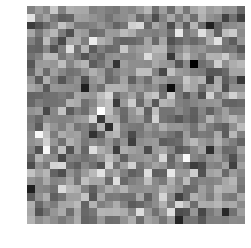

Iteration 73;


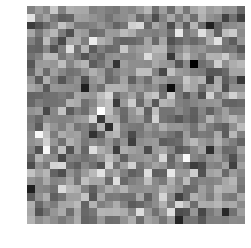

Iteration 74;


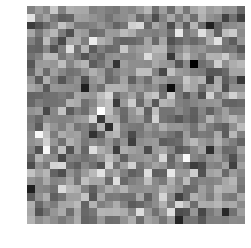

Iteration 75;


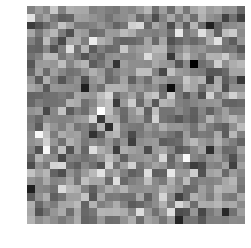

Iteration 76;


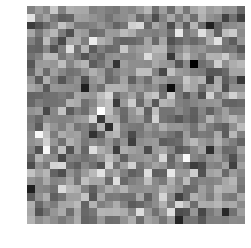

Iteration 77;


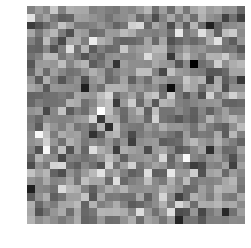

Iteration 78;


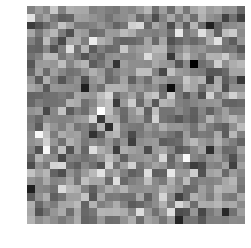

Iteration 79;


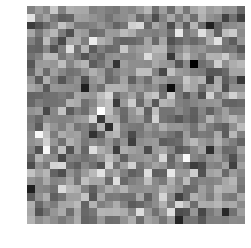

Iteration 80;


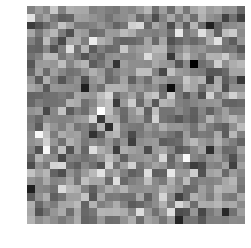

Iteration 81;


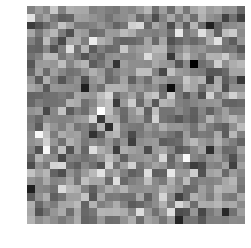

Iteration 82;


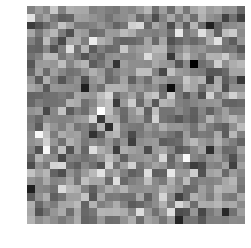

Iteration 83;


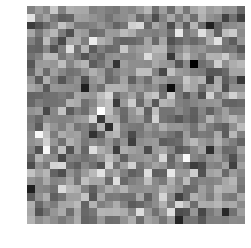

Iteration 84;


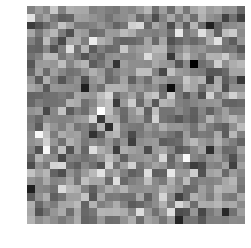

Iteration 85;


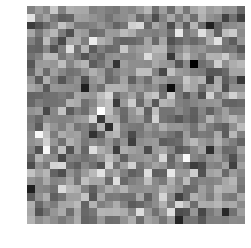

Iteration 86;


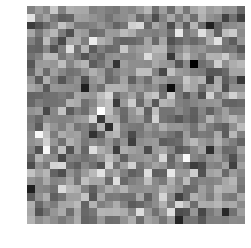

Iteration 87;


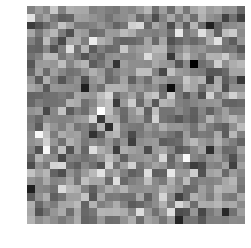

Iteration 88;


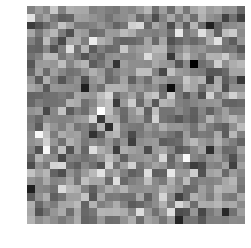

Iteration 89;


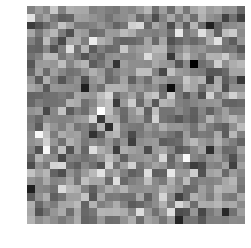

Iteration 90;


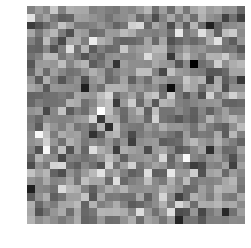

Iteration 91;


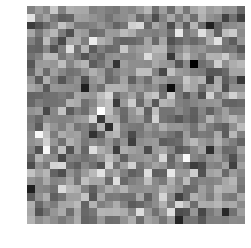

Iteration 92;


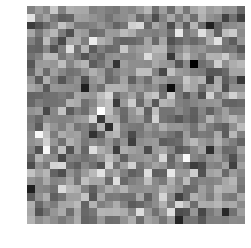

KeyboardInterrupt: ignored

In [14]:
# Train
n_dsc_steps = 1
params_dsc = init_dsc_params
opt = rmsprop

def objective_outer(params_gen, t):
    global params_dsc
    real_data = images[t % num_batches].reshape(batch_size, 28*28)
    
    def objective_inner(params_dsc, t):
        noise_inner = npr.rand(batch_size, noise_dim)
        fake_data_inner = generator(params_gen, noise_inner)
        return(np.log(discriminator(params_dsc, real_data)).mean() + 
               np.log(1 - discriminator(params_dsc, fake_data_inner))).mean()
        
    params_dsc = opt(grad(objective_inner), params_dsc,
                     step_size=0.01, num_iters=n_dsc_steps)
    
    noise_outer = npr.rand(batch_size, noise_dim)
    fake_data_outer = generator(params_gen, noise_outer)
    return np.log(discriminator(params_dsc, fake_data_outer)).mean()

z = npr.rand(1, noise_dim)
def callback(params_gen, t, gradient):    
    print(f'Iteration {t};')
#     print(f'z.mean() = {z.mean()}')
#     print(f'params_gen = {params_gen[0][0].mean()}')
#     print(f'params_dsc = {params_dsc[0][0].mean()}')
    
    fake_image = generator(params_gen, z)
    show_image(fake_image.reshape(28, 28))

params_gen = opt(grad(objective_outer), 
                 init_gen_params,
                 step_size=0.1,
                 num_iters=num_epochs*num_batches,
                 callback=callback)

## PyTorch

**References:**
* https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/gan/gan.py

In [14]:
import torch
import numpy as np

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F

print("GPU Available? =", torch.cuda.is_available())
print("Modules versions:")
!pip freeze | grep -E '^numpy==|^pandas==|^torch==|^torchvision=='

GPU Available? = False
Modules versions:
numpy==1.16.4
pandas==0.24.2
torch==1.1.0
torchvision==0.3.0


In [0]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

In [0]:
img_shape = (1, 28, 28)
cuda = True if torch.cuda.is_available() else False
latent_dim = 100